In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
import json

In [2]:
from keras.models import load_model

best_model = load_model('../models/daily_market.h5')

Using Theano backend.


In [3]:
import pickle

scaler = pickle.load(open('../models/scaler_market.pkl', 'rb'))

In [4]:
import json

COLUMNS = []
with open('../models/columns.json') as column_file:
    COLUMNS = json.load(column_file)
#     COLUMNS = list(filter(lambda x: 'market' not in x, COLUMNS))

In [5]:
sp_100 = pd.read_csv('../data/raw/sp-100-index-06-03-2020.csv')
symbols = sp_100.Symbol.to_numpy()[:-1]

symbols.dump('../files/public/sp_100.json')

In [6]:
backtest_stocks = pd.read_hdf('../data/clean/computed_stocks.h5', key='top_stocks')
backtest_stocks.index = pd.to_datetime(backtest_stocks.index)
backtest_stocks = backtest_stocks['2008']

In [7]:
def backtest(forecasts, predictions, signal, trade=100):
    baseline = trade
    model = trade
    position = trade
    
    signal_active = False
    for date, prediction in zip(forecasts.index, predictions):
        if prediction > signal:
            if signal_active == False:
                position = trade
                signal_active = True
        elif prediction <= signal:
            if signal_active == True:
                model += position - trade
                signal_active = False
        if signal_active == True:
            position += position * forecasts[date]
        baseline += baseline * forecasts[date]
        
    if signal_active == True:
        model += position - trade
    return baseline, model

In [8]:
def backtest_info(forecasts, predictions, signal, trade=100):
    baseline = trade
    model = trade
    position = trade
    
    profit = 0
    loss = 0
    profitable_trades = 0
    unprofitable_trades = 0
    
    signal_active = False
    for date, prediction in zip(forecasts.index, predictions):
        if prediction > signal:
            if signal_active == False:
                position = trade
                signal_active = True
        elif prediction <= signal:
            if signal_active == True:
                model += position - trade
                signal_active = False
        if signal_active == True:
            # gather diagnostic information
            change = position * forecasts[date]
            if change > 0:
                profit += change
                profitable_trades += 1
            else:
                loss += change
                unprofitable_trades += 1
            position += change
        baseline += baseline * forecasts[date]
        
    if signal_active == True:
        model += position - trade
    return baseline, model, profit, loss, profitable_trades, unprofitable_trades

In [9]:
def backtest_animation(forecasts, predictions, buy_signals, symbol, year, file_name, trade=100):
    baseline = trade
    baseline_profits = []
    
    models = [trade] * len(buy_signals)
    positions = [trade] * len(buy_signals)
    signals = [False] * len(buy_signals)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    camera = Camera(fig)
    plt.title(f'Profit Comparison of Model and $100 Investment ({symbol} {year})')
    plt.xlabel('Date')
    plt.ylabel('Profit (USD)')

    colors = ['g']
    
    dates = []
    profits = [[] for i in range(len(buy_signals))]
    
    for date, prediction in zip(forecasts.index, predictions):
        dates.append(date)
        for i, signal in enumerate(signals):
            if prediction >= buy_signals[i]:
                if signals[i] == False:
                    positions[i] = trade
                    signals[i] = True
            elif prediction < buy_signals[i]:
                if signals[i] == True:
                    models[i] += positions[i] - trade
                    signals[i] = False
            if signals[i] == True:
                positions[i] += positions[i] * forecasts[date]
            profit = (models[i] - trade) + (positions[i] - trade)
            profits[i].append(profit)
            plt.plot(dates, profits[i], c=colors[i], label=f'Signal {buy_signals[i]}')
        baseline += baseline * forecasts[date]
        baseline_profits.append(baseline - trade)
        plt.plot(dates, baseline_profits, c='red', label='baseline')
        
        plt.text(0.03, 0.92, "0.5 Buy Signal", fontdict={'size': '10', 
                                                         'color': 'green',
                                                         'weight': 'bold'}, transform=ax.transAxes)
        plt.text(0.03, 0.83, "$100 Investment", fontdict={'size': '10',
                                                          'color': 'red',
                                                          'weight': 'bold'}, transform=ax.transAxes)
        camera.snap()
    
    for i, signal in enumerate(signals):
        if signal == True:
            models[i] += positions[i] - trade
    
    for _ in range(60):
        for i, signal in enumerate(signals):
            plt.plot(dates, profits[i], c=colors[i], label=f'Signal {buy_signals[i]}')
        plt.plot(dates, baseline_profits, c='red', label='baseline')
        
        plt.text(0.03, 0.92, "0.5 Buy Signal", fontdict={'size': '10', 
                                                         'color': 'green',
                                                         'weight': 'bold'}, transform=ax.transAxes)
        plt.text(0.03, 0.83, "$100 Investment", fontdict={'size': '10',
                                                          'color': 'red',
                                                          'weight': 'bold'}, transform=ax.transAxes)
        camera.snap() 
    
    animation = camera.animate()
    animation.save(file_name, writer = 'pillow', fps=20)

    return baseline, models

In [10]:
apple = backtest_stocks[backtest_stocks.symbol == 'AMZN']
X = apple[COLUMNS]
X_scaled = scaler.transform(X)
predictions = best_model.predict(X_scaled)[:, 1]
forecasts = apple.forecast

In [11]:
# backtest_animation(forecasts, predictions, [0.5], 'AMZN', '2013', 'amazon_2013.gif')

In [12]:
def max_profit(symbol, plot=False):
    stock = backtest_stocks[backtest_stocks.symbol == symbol].copy()
    X = stock[COLUMNS]
    if X.shape[0] == 0:
        return 0, -1, []
    X_scaled = scaler.transform(X)
    predictions = best_model.predict(X_scaled)[:, 1]
    
    buy_signals = np.arange(0, 1, 0.01)
    profits = []
    max_profit = -100
    best_signal = 0
    for buy_signal in buy_signals:
        _, model = backtest(stock.forecast, predictions, buy_signal)
        profit = model - 100
        if profit > max_profit:
            max_profit = profit
            best_signal = buy_signal
        profits.append(model - 100)
            
    adjusted_profits = [(profit - min(profits)) / (max(profits) - min(profits)) for profit in profits]
    
    if plot:
        plt.plot(buy_signals, adjusted_profits)
        plt.show()
    
    return max_profit, best_signal, adjusted_profits

In [13]:
best_signals = []
average_profits = np.full(100, 0.0)
num_valid = 0
for symbol in tqdm(symbols):
    profit, signal, adjusted_profits = max_profit(symbol)
    if signal >= 0:
        num_valid += 1
        best_signals.append(signal)
        average_profits += adjusted_profits

average_profits /= num_valid

(0.9562424160885239, 0.48)

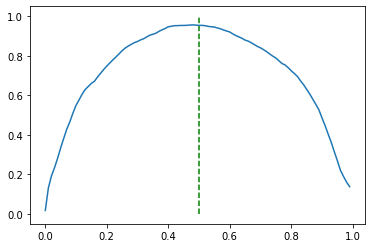

In [14]:
signals = np.arange(0, 1, 0.01)
plt.plot(signals, average_profits)
plt.vlines([0.5], ymin=0, ymax=1, linestyles='--', colors=['g'])
best_signal = np.argmax(average_profits)
average_profits[best_signal], signals[best_signal]

In [15]:
def model_success(symbol, signal):
    stock = backtest_stocks[backtest_stocks.symbol == symbol].copy()
    X = stock[COLUMNS]
    X_scaled = scaler.transform(X)
    predictions = best_model.predict(X_scaled)[:, 1]
    stock['prediction'] = predictions
    
    stock_up_correct = stock[(stock.prediction >= signal) & (stock.forecast >= 0)]
    stock_up_incorrect = stock[(stock.prediction >= signal) & (stock.forecast < 0)]
    stock_down_correct = stock[(stock.prediction < signal) & (stock.forecast < 0)]
    stock_down_incorrect = stock[(stock.prediction < signal) & (stock.forecast >= 0)]
    
    _ = plt.plot(stock_up_correct.close, marker='^', linestyle='None', c='g', label='UP (Correct)')
    _ = plt.plot(stock_up_incorrect.close, marker='^', linestyle='None', c='r', label='UP (Incorrect)')
    _ = plt.plot(stock_down_correct.close, marker='v', linestyle='None', c='g', label='DOWN (Correct)')
    _ = plt.plot(stock_down_incorrect.close, marker='v', linestyle='None', c='r', label='DOWN (Incorrect)')
    _ = plt.plot(stock.close)
    _ = plt.legend()

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


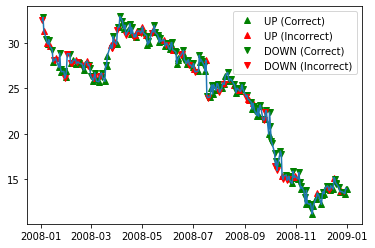

In [16]:
model_success('EBAY', 0.5)

In [17]:
from tqdm.notebook import tqdm

def calculate_profit(symbol, buy):
    X = backtest_stocks[backtest_stocks.symbol == symbol][COLUMNS]
    if X.shape[0] == 0:
        return 100, 100, 0, 0, 0, 0
    X_scaled = scaler.transform(X)
    predictions = best_model.predict(X_scaled)[:, 1]
    forecasts = backtest_stocks[backtest_stocks.symbol == symbol].forecast
    
    X_market = backtest_stocks[backtest_stocks.symbol == 'SPY'][COLUMNS]
    X_scaled_market = scaler.transform(X_market)
    predictions_market = best_model.predict(X_scaled_market)[:, 1]
    
    return backtest_info(forecasts, predictions, buy)

baselines = []
models = []
profits = []
losses = []
profitable_trades = []
unprofitable_trades = []


num_symbols = len(symbols)

for symbol in tqdm(symbols[:num_symbols]):
    baseline, model, profit, loss, profitable, unprofitable = calculate_profit(symbol, .5)
    if baseline == 0:
        num_symbols -= 1
    baselines.append(baseline)
    models.append(model)
    profits.append(profit)
    losses.append(loss)
    profitable_trades.append(profitable)
    unprofitable_trades.append(unprofitable)

print(num_symbols * 100)
print(sum(baselines), sum(models))
print(sum(profits), sum(losses))
print(sum(profitable_trades), sum(unprofitable_trades))


10100
7693.866119496513 29788.807437010793
23276.982306778402 -3588.174869767594
7784 2616
